In [1]:
import pandas as pd
from pyspark.sql import SparkSession
import os
import matplotlib.pyplot as plt
from tabulate import tabulate

### Config

In [2]:
# Determine whether to materialize the parameters of models
SAVE_MODEL = False

### Preprocess

In [3]:
if not os.path.exists('./car_prices_without_null.csv'):
    # 加载数据
    df = pd.read_csv('./car_prices.csv')

    # 检查所有列
    print(df.info())

    # 删除包含空值的行
    df = df.dropna()

    # 写入新文件
    df.to_csv('./car_prices_without_null.csv', index=False)

In [4]:
spark = SparkSession.builder.appName('5003_project').getOrCreate()
sc = spark.sparkContext

your 131072x1 screen size is bogus. expect trouble


24/04/28 16:53:00 WARN Utils: Your hostname, SIMON_WANG resolves to a loopback address: 127.0.1.1; using 172.26.40.34 instead (on interface eth0)
24/04/28 16:53:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/04/28 16:53:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
spark.version

'3.3.2'

In [6]:
data = spark.read.csv('./car_prices_without_null.csv', header=True, inferSchema=True)
data.show(10)

+----+---------+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-------+------------+--------------------+
|year|     make|              model|                trim|       body|transmission|              vin|state|condition|odometer|color|interior|              seller|    mmr|sellingprice|            saledate|
+----+---------+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-------+------------+--------------------+
|2015|      Kia|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg566472|   ca|      5.0| 16639.0|white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|      Kia|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg561319|   ca|      5.0|  9393.0|white|   beige|kia motors americ...|20800.0|     21500.0|Tu

In [7]:
data.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: double (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: double (nullable = true)
 |-- sellingprice: double (nullable = true)
 |-- saledate: string (nullable = true)



In [8]:
data.rdd.getNumPartitions()

19

### Data Cleaning

In [9]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer

# 创建StringIndexer对象
stringIndexer = StringIndexer(inputCol="make", outputCol="make_index")

# 使用StringIndexer对象进行转换
indexedData = stringIndexer.fit(data).transform(data)

# 将"make_index"列转换为整数类型
indexedData = indexedData.withColumn("make_index", col("make_index").cast(IntegerType()))

# 替换"make"列为"make_index"列
indexedData = indexedData.withColumn("make", col("make_index")).drop("make_index")

# 查看转换后的数据
data = indexedData
data.show()

+----+----+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|make|              model|                trim|       body|transmission|              vin|state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015|   8|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg566472|   ca|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg561319|   ca|      5.0|  9393.0| white|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|


In [10]:
# 处理state列
stringIndexer = StringIndexer(inputCol="state", outputCol="state_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("state_index", col("state_index").cast(IntegerType()))
indexedData = indexedData.withColumn("state", col("state_index")).drop("state_index")

data = indexedData
data.show()

+----+----+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|make|              model|                trim|       body|transmission|              vin|state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015|   8|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg566472|    1|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg561319|    1|      5.0|  9393.0| white|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|


In [11]:
# 处理model列
stringIndexer = StringIndexer(inputCol="model", outputCol="model_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("model_index", col("model_index").cast(IntegerType()))
indexedData = indexedData.withColumn("model", col("model_index")).drop("model_index")

data = indexedData
data.show()

+----+----+-----+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|make|model|                trim|       body|transmission|              vin|state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-----+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015|   8|   40|                  LX|        SUV|   automatic|5xyktca69fg566472|    1|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|   40|                  LX|        SUV|   automatic|5xyktca69fg561319|    1|      5.0|  9393.0| white|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|
|2014|   7|    8|          328i SULEV|      Sedan|   automatic|wba3c1c

In [12]:
# 处理transmission
stringIndexer = StringIndexer(inputCol="transmission", outputCol="transmission_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("transmission_index", col("transmission_index").cast(IntegerType()))
indexedData = indexedData.withColumn("transmission", col("transmission_index")).drop("transmission_index")

data = indexedData
data.show()

+----+----+-----+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|make|model|                trim|       body|transmission|              vin|state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-----+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015|   8|   40|                  LX|        SUV|           0|5xyktca69fg566472|    1|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|   40|                  LX|        SUV|           0|5xyktca69fg561319|    1|      5.0|  9393.0| white|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|
|2014|   7|    8|          328i SULEV|      Sedan|           0|wba3c1c

In [13]:
# 处理trim
stringIndexer = StringIndexer(inputCol="trim", outputCol="trim_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("trim_index", col("trim_index").cast(IntegerType()))
indexedData = indexedData.withColumn("trim", col("trim_index")).drop("trim_index")

data = indexedData
data.show()

+----+----+-----+----+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|make|model|trim|       body|transmission|              vin|state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-----+----+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015|   8|   40|   2|        SUV|           0|5xyktca69fg566472|    1|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|   40|   2|        SUV|           0|5xyktca69fg561319|    1|      5.0|  9393.0| white|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|
|2014|   7|    8| 636|      Sedan|           0|wba3c1c51ek116351|    1|     45.0|  1331.0|  gray|   black|financial service...|31900.0|     30000.0|Th

In [14]:
# 处理body
stringIndexer = StringIndexer(inputCol="body", outputCol="body_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("body_index", col("body_index").cast(IntegerType()))
indexedData = indexedData.withColumn("body", col("body_index")).drop("body_index")

data = indexedData
data.show()

+----+----+-----+----+----+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|make|model|trim|body|transmission|              vin|state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-----+----+----+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015|   8|   40|   2|   1|           0|5xyktca69fg566472|    1|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|   40|   2|   1|           0|5xyktca69fg561319|    1|      5.0|  9393.0| white|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|
|2014|   7|    8| 636|   0|           0|wba3c1c51ek116351|    1|     45.0|  1331.0|  gray|   black|financial service...|31900.0|     30000.0|Thu Jan 15 2015 0...|
|2015|  26|  127|  91|

In [15]:
# 处理color
stringIndexer = StringIndexer(inputCol="color", outputCol="color_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("color_index", col("color_index").cast(IntegerType()))
indexedData = indexedData.withColumn("color", col("color_index")).drop("color_index")

data = indexedData
data.show()

+----+----+-----+----+----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-------+------------+--------------------+
|year|make|model|trim|body|transmission|              vin|state|condition|odometer|color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-----+----+----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-------+------------+--------------------+
|2015|   8|   40|   2|   1|           0|5xyktca69fg566472|    1|      5.0| 16639.0|    1|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|   40|   2|   1|           0|5xyktca69fg561319|    1|      5.0|  9393.0|    1|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|
|2014|   7|    8| 636|   0|           0|wba3c1c51ek116351|    1|     45.0|  1331.0|    3|   black|financial service...|31900.0|     30000.0|Thu Jan 15 2015 0...|
|2015|  26|  127|  91|   0| 

In [16]:
# 处理interior
stringIndexer = StringIndexer(inputCol="interior", outputCol="interior_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("interior_index", col("interior_index").cast(IntegerType()))
indexedData = indexedData.withColumn("interior", col("interior_index")).drop("interior_index")

data = indexedData
data.show()

+----+----+-----+----+----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-------+------------+--------------------+
|year|make|model|trim|body|transmission|              vin|state|condition|odometer|color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-----+----+----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-------+------------+--------------------+
|2015|   8|   40|   2|   1|           0|5xyktca69fg566472|    1|      5.0| 16639.0|    1|       0|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|   40|   2|   1|           0|5xyktca69fg561319|    1|      5.0|  9393.0|    1|       2|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|
|2014|   7|    8| 636|   0|           0|wba3c1c51ek116351|    1|     45.0|  1331.0|    3|       0|financial service...|31900.0|     30000.0|Thu Jan 15 2015 0...|
|2015|  26|  127|  91|   0| 

In [17]:
# 处理seller
stringIndexer = StringIndexer(inputCol="seller", outputCol="seller_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("seller_index", col("seller_index").cast(IntegerType()))
indexedData = indexedData.withColumn("seller", col("seller_index")).drop("seller_index")

data = indexedData
data.show()

+----+----+-----+----+----+------------+-----------------+-----+---------+--------+-----+--------+------+-------+------------+--------------------+
|year|make|model|trim|body|transmission|              vin|state|condition|odometer|color|interior|seller|    mmr|sellingprice|            saledate|
+----+----+-----+----+----+------------+-----------------+-----+---------+--------+-----+--------+------+-------+------------+--------------------+
|2015|   8|   40|   2|   1|           0|5xyktca69fg566472|    1|      5.0| 16639.0|    1|       0|    23|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|   40|   2|   1|           0|5xyktca69fg561319|    1|      5.0|  9393.0|    1|       2|    23|20800.0|     21500.0|Tue Dec 16 2014 1...|
|2014|   7|    8| 636|   0|           0|wba3c1c51ek116351|    1|     45.0|  1331.0|    3|       0|    14|31900.0|     30000.0|Thu Jan 15 2015 0...|
|2015|  26|  127|  91|   0|           0|yv1612tb4f1310987|    1|     41.0| 14282.0|    1|       0|   123|27500.0

In [18]:
# 显示"saledate"列的前10条数据
saledate_data = data.select("saledate").head(10)

# 打印前10条数据
for row in saledate_data:
    print(row.saledate)

Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
Thu Dec 18 2014 12:30:00 GMT-0800 (PST)
Tue Dec 30 2014 12:00:00 GMT-0800 (PST)
Wed Dec 17 2014 12:30:00 GMT-0800 (PST)
Tue Dec 16 2014 13:00:00 GMT-0800 (PST)
Thu Dec 18 2014 12:00:00 GMT-0800 (PST)
Tue Jan 20 2015 04:00:00 GMT-0800 (PST)


In [19]:
from pyspark.sql.functions import substring, unix_timestamp

# 将"timestamp_string"列转换为Unix时间戳
data = data.withColumn("timestamp_string", substring("saledate", 5, 20))
data = data.withColumn("timestamp", unix_timestamp("timestamp_string", "MMM dd yyyy HH:mm:ss"))

data = data.drop('saledate')
data = data.drop('timestamp_string')
data = data.drop('vin')

# 查看转换后的数据
data.show()

+----+----+-----+----+----+------------+-----+---------+--------+-----+--------+------+-------+------------+----------+
|year|make|model|trim|body|transmission|state|condition|odometer|color|interior|seller|    mmr|sellingprice| timestamp|
+----+----+-----+----+----+------------+-----+---------+--------+-----+--------+------+-------+------------+----------+
|2015|   8|   40|   2|   1|           0|    1|      5.0| 16639.0|    1|       0|    23|20500.0|     21500.0|1418704200|
|2015|   8|   40|   2|   1|           0|    1|      5.0|  9393.0|    1|       2|    23|20800.0|     21500.0|1418704200|
|2014|   7|    8| 636|   0|           0|    1|     45.0|  1331.0|    3|       0|    14|31900.0|     30000.0|1421267400|
|2015|  26|  127|  91|   0|           0|    1|     41.0| 14282.0|    1|       0|   123|27500.0|     27750.0|1422477000|
|2014|   7|  398| 139|   0|           0|    1|     43.0|  2641.0|    3|       0|    14|66000.0|     67000.0|1418877000|
|2015|   2|    0|  12|   0|           0|

In [20]:
# 将"timestamp"列丢弃末两位
data = data.withColumn("timestamp_str", data["timestamp"].cast("string"))
data = data.withColumn("timestamp_str_truncated", substring("timestamp_str", 0, 8))
data = data.withColumn("timestamp_int", data["timestamp_str_truncated"].cast("integer"))

data = data.drop('timestamp_str')
data = data.drop('timestamp_str_truncated')
data = data.drop('timestamp')
data = data.withColumnRenamed("timestamp_int", "timestamp")


data.show()

+----+----+-----+----+----+------------+-----+---------+--------+-----+--------+------+-------+------------+---------+
|year|make|model|trim|body|transmission|state|condition|odometer|color|interior|seller|    mmr|sellingprice|timestamp|
+----+----+-----+----+----+------------+-----+---------+--------+-----+--------+------+-------+------------+---------+
|2015|   8|   40|   2|   1|           0|    1|      5.0| 16639.0|    1|       0|    23|20500.0|     21500.0| 14187042|
|2015|   8|   40|   2|   1|           0|    1|      5.0|  9393.0|    1|       2|    23|20800.0|     21500.0| 14187042|
|2014|   7|    8| 636|   0|           0|    1|     45.0|  1331.0|    3|       0|    14|31900.0|     30000.0| 14212674|
|2015|  26|  127|  91|   0|           0|    1|     41.0| 14282.0|    1|       0|   123|27500.0|     27750.0| 14224770|
|2014|   7|  398| 139|   0|           0|    1|     43.0|  2641.0|    3|       0|    14|66000.0|     67000.0| 14188770|
|2015|   2|    0|  12|   0|           0|    1|  

In [21]:
data.printSchema()
print(data.dtypes)

root
 |-- year: integer (nullable = true)
 |-- make: integer (nullable = true)
 |-- model: integer (nullable = true)
 |-- trim: integer (nullable = true)
 |-- body: integer (nullable = true)
 |-- transmission: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: double (nullable = true)
 |-- color: integer (nullable = true)
 |-- interior: integer (nullable = true)
 |-- seller: integer (nullable = true)
 |-- mmr: double (nullable = true)
 |-- sellingprice: double (nullable = true)
 |-- timestamp: integer (nullable = true)

[('year', 'int'), ('make', 'int'), ('model', 'int'), ('trim', 'int'), ('body', 'int'), ('transmission', 'int'), ('state', 'int'), ('condition', 'double'), ('odometer', 'double'), ('color', 'int'), ('interior', 'int'), ('seller', 'int'), ('mmr', 'double'), ('sellingprice', 'double'), ('timestamp', 'int')]


In [22]:
# 1. 检查数据中是否存在 null 值
null_cols = [col for col in data.columns if data.select(col).where(data[col].isNull()).count() > 0]
if null_cols:
    print(f"Null values found in columns: {', '.join(null_cols)}")

In [23]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = ['year', 'make', 'model', 'trim','body', 'transmission', 'state', 'condition', 'odometer', 'color', 'interior', 'seller', 'mmr', 'timestamp'], outputCol = 'features')
output = assembler.transform(data)
output.show(1)

24/04/28 16:53:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+----+----+-----+----+----+------------+-----+---------+--------+-----+--------+------+-------+------------+---------+--------------------+
|year|make|model|trim|body|transmission|state|condition|odometer|color|interior|seller|    mmr|sellingprice|timestamp|            features|
+----+----+-----+----+----+------------+-----+---------+--------+-----+--------+------+-------+------------+---------+--------------------+
|2015|   8|   40|   2|   1|           0|    1|      5.0| 16639.0|    1|       0|    23|20500.0|     21500.0| 14187042|[2015.0,8.0,40.0,...|
+----+----+-----+----+----+------------+-----+---------+--------+-----+--------+------+-------+------------+---------+--------------------+
only showing top 1 row



In [24]:
output.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: integer (nullable = true)
 |-- model: integer (nullable = true)
 |-- trim: integer (nullable = true)
 |-- body: integer (nullable = true)
 |-- transmission: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: double (nullable = true)
 |-- color: integer (nullable = true)
 |-- interior: integer (nullable = true)
 |-- seller: integer (nullable = true)
 |-- mmr: double (nullable = true)
 |-- sellingprice: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- features: vector (nullable = true)



In [25]:
final_data = output.select(['features', 'sellingprice'])
final_data = final_data.dropna()
final_data.show(3, truncate=False)

+-------------------------------------------------------------------------------+------------+
|features                                                                       |sellingprice|
+-------------------------------------------------------------------------------+------------+
|[2015.0,8.0,40.0,2.0,1.0,0.0,1.0,5.0,16639.0,1.0,0.0,23.0,20500.0,1.4187042E7] |21500.0     |
|[2015.0,8.0,40.0,2.0,1.0,0.0,1.0,5.0,9393.0,1.0,2.0,23.0,20800.0,1.4187042E7]  |21500.0     |
|[2014.0,7.0,8.0,636.0,0.0,0.0,1.0,45.0,1331.0,3.0,0.0,14.0,31900.0,1.4212674E7]|30000.0     |
+-------------------------------------------------------------------------------+------------+
only showing top 3 rows



In [26]:
final_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- sellingprice: double (nullable = true)



In [27]:
final_data.describe().show()

+-------+-----------------+
|summary|     sellingprice|
+-------+-----------------+
|  count|           472325|
|   mean|13690.51205843434|
| stddev|  9613.0337376916|
|    min|              1.0|
|    max|         230000.0|
+-------+-----------------+



### Train-Test Split

In [28]:
train, test = final_data.randomSplit([0.8,0.2])

In [29]:
# 查看数量
train_count = train.count()
test_count = test.count()
print("Number of samples in train set:", train_count)
print("Number of samples in test set:", test_count)

Number of samples in train set: 377984
Number of samples in test set: 94341


### Evaluation Function

In [30]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="sellingprice", predictionCol="prediction")

def evaluate(pred):
    rmse = evaluator.evaluate(pred, {evaluator.metricName: "rmse"})
    r2 = evaluator.evaluate(pred, {evaluator.metricName: "r2"})
    mae = evaluator.evaluate(pred, {evaluator.metricName: "mae"})

    return rmse, r2, mae


### Model Save Function

In [31]:
def save_model(model, name):
    if SAVE_MODEL:
        if not os.path.exists('models'):
            os.makedirs('models')
        model.write().overwrite().save(f'models/{name}')

### Timer

In [32]:
import time
times = []

def timer(f):

    def func(*arg, **kwarg):
        s_time = time.time()
        res = f(*arg,**kwarg)
        e_time = time.time()
        t = e_time - s_time
        print(f'It took {t} second(s)')
        times.append(t)
        return res
    
    return func

### Linear Regression

In [33]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='sellingprice')

In [34]:
@timer
def lr_training():
    return lr.fit(train)

lr_model = lr_training()
# lr_model = lr.fit(train)

24/04/28 16:53:18 WARN Instrumentation: [490ae4dc] regParam is zero, which might cause numerical instability and overfitting.


24/04/28 16:53:19 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/28 16:53:19 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


24/04/28 16:53:20 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


It took 2.7373340129852295 second(s)


In [35]:
lr_predictions = lr_model.transform(test)
lr_predictions.show(10)

+--------------------+------------+------------------+
|            features|sellingprice|        prediction|
+--------------------+------------+------------------+
|(14,[0,1,2,3,7,8,...|     11600.0|13672.725681690863|
|(14,[0,1,2,6,7,8,...|     23000.0| 22542.21501311951|
|(14,[0,1,2,7,8,10...|     16200.0| 16999.78458415094|
|(14,[0,1,2,7,8,11...|     13800.0|13118.181312620509|
|(14,[0,1,2,7,8,11...|     11000.0|11486.363472308716|
|(14,[0,1,3,7,8,11...|      8300.0| 9898.864702246283|
|(14,[0,2,3,4,7,8,...|     11400.0|  8902.00750088344|
|(14,[0,2,3,6,7,8,...|     13700.0|13169.837330531853|
|(14,[0,2,3,6,7,8,...|     21600.0| 18862.05737520907|
|(14,[0,2,3,6,7,8,...|     15500.0|15339.777372104785|
+--------------------+------------+------------------+
only showing top 10 rows



In [36]:
lr_rmse, lr_r2, lr_mae = evaluate(lr_predictions)
lr_rmse, lr_r2, lr_mae

(1632.7629738786432, 0.9705629437330588, 1040.681250624177)

In [37]:
save_model(lr_model, 'linear_regression')

### Decision Tree

In [38]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol='features', labelCol='sellingprice')

In [39]:
@timer
def dt_training():
    return dt.fit(train)

dt_model = dt_training()
# dt_model = dt.fit(train)

It took 3.50244402885437 second(s)


In [40]:
dt_predictions = dt_model.transform(test)
dt_predictions.show(10)

+--------------------+------------+------------------+
|            features|sellingprice|        prediction|
+--------------------+------------+------------------+
|(14,[0,1,2,3,7,8,...|     11600.0|13795.323770368814|
|(14,[0,1,2,6,7,8,...|     23000.0| 22121.51058599635|
|(14,[0,1,2,7,8,10...|     16200.0|15960.205095502717|
|(14,[0,1,2,7,8,11...|     13800.0|13795.323770368814|
|(14,[0,1,2,7,8,11...|     11000.0|11944.643884975707|
|(14,[0,1,3,7,8,11...|      8300.0| 9099.749898728023|
|(14,[0,2,3,4,7,8,...|     11400.0| 9099.749898728023|
|(14,[0,2,3,6,7,8,...|     13700.0|13795.323770368814|
|(14,[0,2,3,6,7,8,...|     21600.0|19586.732729959363|
|(14,[0,2,3,6,7,8,...|     15500.0|15960.205095502717|
+--------------------+------------+------------------+
only showing top 10 rows



In [41]:
dt_rmse, dt_r2, dt_mae = evaluate(dt_predictions)
dt_rmse, dt_r2, dt_mae

(2283.0421392712396, 0.9424459424887894, 1273.8885455971506)

In [42]:
save_model(dt_model, 'decision_tree')

### Random Forest

In [43]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features', labelCol='sellingprice')

In [44]:
@timer
def rf_training():
    return rf.fit(train)

rf_model = rf_training()
# rf_model = rf.fit(train)

It took 3.395118474960327 second(s)


In [45]:
rf_predictions = rf_model.transform(test)
rf_predictions.show(10)

+--------------------+------------+------------------+
|            features|sellingprice|        prediction|
+--------------------+------------+------------------+
|(14,[0,1,2,3,7,8,...|     11600.0|12509.964372766435|
|(14,[0,1,2,6,7,8,...|     23000.0|21448.495688392086|
|(14,[0,1,2,7,8,10...|     16200.0| 15679.41529417806|
|(14,[0,1,2,7,8,11...|     13800.0|12755.242096026028|
|(14,[0,1,2,7,8,11...|     11000.0|11491.250968729497|
|(14,[0,1,3,7,8,11...|      8300.0|10624.413161242648|
|(14,[0,2,3,4,7,8,...|     11400.0| 7752.321560549036|
|(14,[0,2,3,6,7,8,...|     13700.0|13129.891220066285|
|(14,[0,2,3,6,7,8,...|     21600.0|19824.545268320602|
|(14,[0,2,3,6,7,8,...|     15500.0|15070.589481414636|
+--------------------+------------+------------------+
only showing top 10 rows



In [46]:
rf_rmse, rf_r2, rf_mae = evaluate(rf_predictions)
rf_rmse, rf_r2, rf_mae

(2878.8807532311816, 0.9084843341723676, 1573.627402648618)

In [47]:
save_model(rf_model, 'random_forest')

### Figures

In [48]:
def get_pandas_predictions(pred):
    return pred.select("prediction").toPandas()

In [49]:
real_price = test.select("sellingprice").toPandas()["sellingprice"]
lr_price = get_pandas_predictions(lr_predictions)
dt_price = get_pandas_predictions(dt_predictions)
rf_price = get_pandas_predictions(rf_predictions)

In [50]:
def draw_comparison_scatter_figure(pandas_data, title = ''):
    # 创建散点图
    plt.figure(figsize=(8,6))

    # 绘制真实汽车价格和预测汽车价格的散点图
    plt.scatter(real_price.values, pandas_data.values, color="blue", alpha=0.5)

    plt.axline((0, 0), slope=1, color='red', linestyle='dashed')

    # 添加标题和坐标轴标签
    plt.title(title)
    plt.xlabel("Real Price")
    plt.ylabel("Predicted Price")

    # 显示图形
    plt.show()

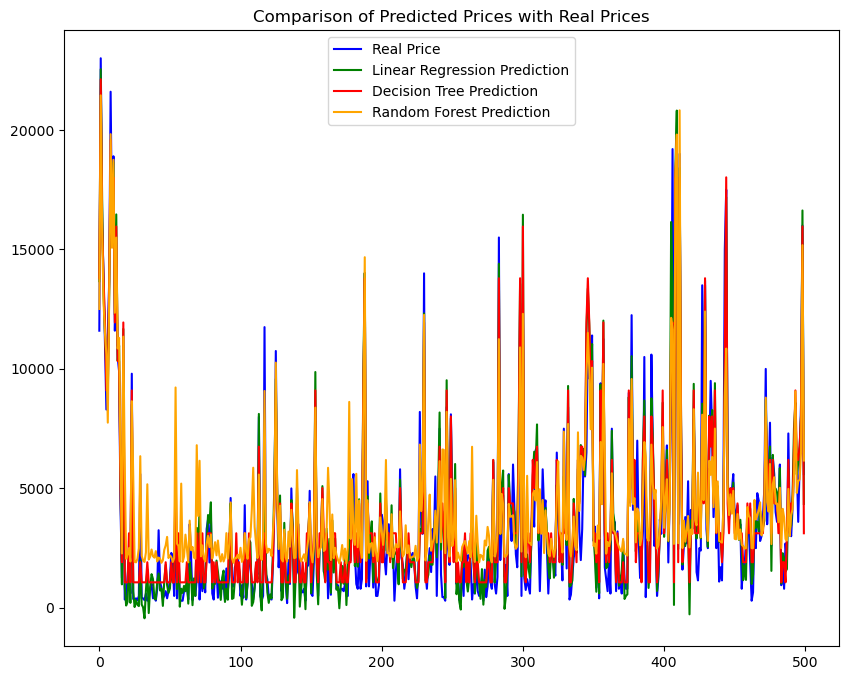

In [51]:
# 创建折线图
plt.figure(figsize=(10, 8))

# 绘制真实汽车价格
plt.plot(real_price[:500], label="Real Price", color="blue")

# 绘制第一种方法的预测价格
plt.plot(lr_price[:500], label="Linear Regression Prediction", color="green")

# 绘制第二种方法的预测价格
plt.plot(dt_price[:500], label="Decision Tree Prediction", color="red")

# 绘制第三种方法的预测价格
plt.plot(rf_price[:500], label="Random Forest Prediction", color="orange")

# 添加标题和图例
plt.title("Comparison of Predicted Prices with Real Prices")
plt.legend()

# 显示图形
plt.show()

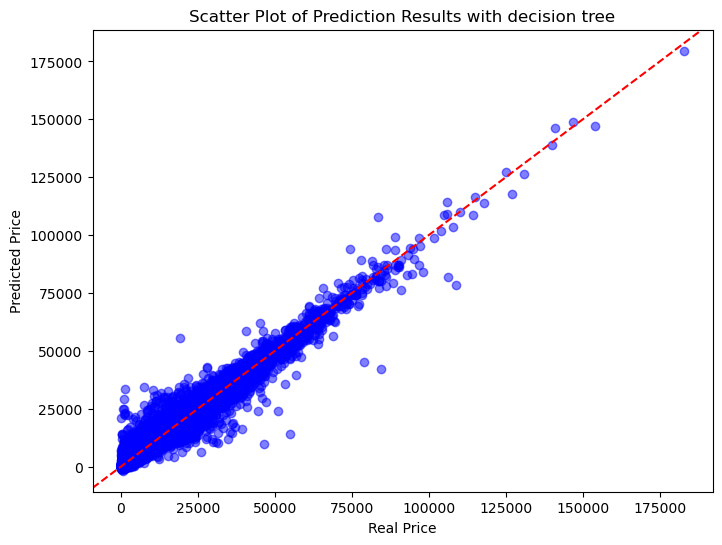

In [52]:
draw_comparison_scatter_figure(lr_price, title="Scatter Plot of Prediction Results with decision tree")

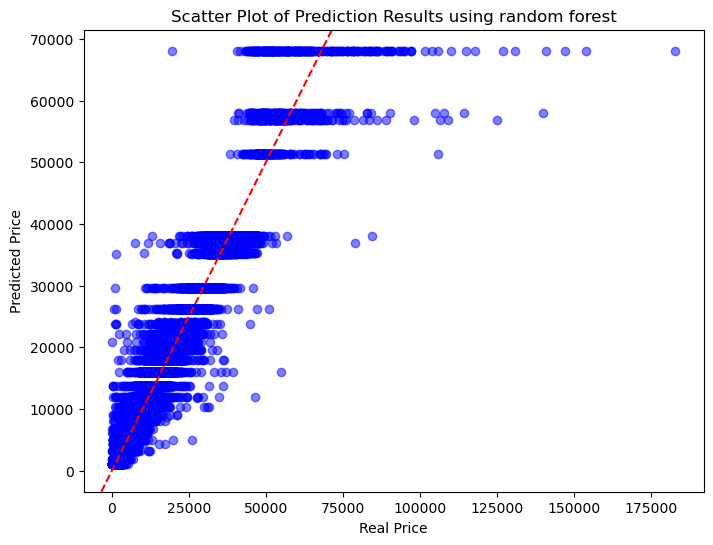

In [53]:
draw_comparison_scatter_figure(dt_price, title="Scatter Plot of Prediction Results using random forest")

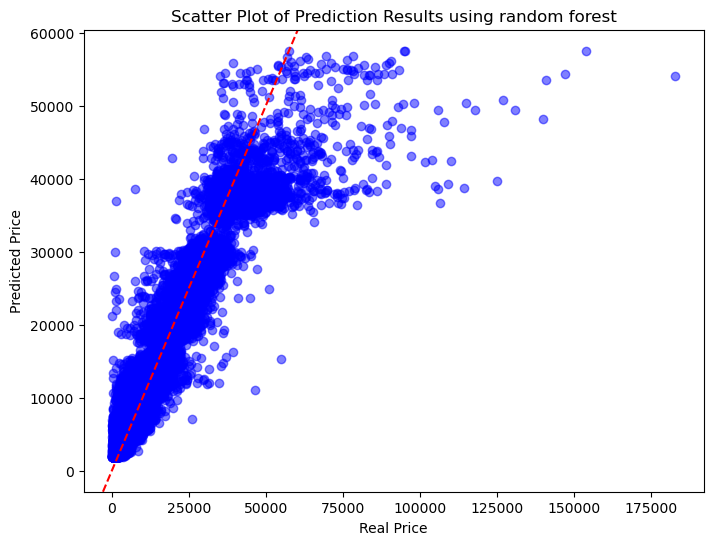

In [54]:
draw_comparison_scatter_figure(rf_price, title="Scatter Plot of Prediction Results using random forest")

In [55]:
# 创建一个列表，包含表头和数据
table = [
    ["Method", "R^2", "RMSE", "MAE"],
    ["Linear Regression", lr_r2, lr_rmse, lr_mae],
    ["Decision Tree", dt_r2, dt_rmse, dt_mae],
    ["Random Forest", rf_r2, rf_rmse, rf_mae]
]

# 使用 tabulate 函数生成表格
table_str = tabulate(table, headers="firstrow", tablefmt="fancy_grid")

# 打印表格
print(table_str)

╒═══════════════════╤══════════╤═════════╤═════════╕
│ Method            │      R^2 │    RMSE │     MAE │
╞═══════════════════╪══════════╪═════════╪═════════╡
│ Linear Regression │ 0.970563 │ 1632.76 │ 1040.68 │
├───────────────────┼──────────┼─────────┼─────────┤
│ Decision Tree     │ 0.942446 │ 2283.04 │ 1273.89 │
├───────────────────┼──────────┼─────────┼─────────┤
│ Random Forest     │ 0.908484 │ 2878.88 │ 1573.63 │
╘═══════════════════╧══════════╧═════════╧═════════╛


### Performance Test

In [56]:
train.rdd.getNumPartitions()

19

In [57]:
one_par_train = train.repartition(1)
one_par_train.rdd.getNumPartitions()

1

In [58]:
lr_single = LinearRegression(featuresCol='features', labelCol='sellingprice')
dt_single = DecisionTreeRegressor(featuresCol='features', labelCol='sellingprice')
rf_single = RandomForestRegressor(featuresCol='features', labelCol='sellingprice')

In [59]:
@timer
def lr_single_training():
    lr_single.fit(one_par_train)

lr_single_training()

24/04/28 16:53:45 WARN Instrumentation: [52799d9c] regParam is zero, which might cause numerical instability and overfitting.


It took 2.4229187965393066 second(s)


In [60]:
@timer
def dt_single_training():
    dt_single.fit(one_par_train)
    
dt_single_training()

It took 1.550349473953247 second(s)


In [61]:
@timer
def rf_single_training():
    rf_single.fit(one_par_train)

rf_single_training()

It took 5.3253014087677 second(s)


In [62]:
times

[2.7373340129852295,
 3.50244402885437,
 3.395118474960327,
 2.4229187965393066,
 1.550349473953247,
 5.3253014087677]

In [70]:
parallel_num = train.rdd.getNumPartitions()
single_num = one_par_train.rdd.getNumPartitions()

print(
    tabulate(
        [
            ["Method", "Partitions", "Time"],
            ["Linear Regression", single_num, times[3]],
            ["Linear Regression", parallel_num, times[0]],
            ["Decision Tree", single_num, times[4]],
            ["Decision Tree", parallel_num, times[1]],
            ["Random Forest", single_num, times[5]],
            ["Random Forest", parallel_num, times[2]],
        ],
        headers="firstrow",
        tablefmt="fancy_grid"
    )
)

System: Linux
Node Name: SIMON_WANG
Release: 5.10.16.3-microsoft-standard-WSL2
Version: #1 SMP Fri Apr 2 22:23:49 UTC 2021
Machine: x86_64
Processor: x86_64
╒═══════════════════╤══════════════╤═════════╕
│ Method            │   Partitions │    Time │
╞═══════════════════╪══════════════╪═════════╡
│ Linear Regression │            1 │ 2.42292 │
├───────────────────┼──────────────┼─────────┤
│ Linear Regression │           19 │ 2.73733 │
├───────────────────┼──────────────┼─────────┤
│ Decision Tree     │            1 │ 1.55035 │
├───────────────────┼──────────────┼─────────┤
│ Decision Tree     │           19 │ 3.50244 │
├───────────────────┼──────────────┼─────────┤
│ Random Forest     │            1 │ 5.3253  │
├───────────────────┼──────────────┼─────────┤
│ Random Forest     │           19 │ 3.39512 │
╘═══════════════════╧══════════════╧═════════╛
